In [ ]:
%pylab inline
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Week 10 Section:
## Gillespie Algorithm and master equations

Things to remember:

- Master equations can be defined in terms of stepped increments and updates.
- The gillespie algorithm allows us to sample probability distributions described by master equations. It's particularly good when we have a complicated system with lots of chemical species, where a Monte Carlo simulation might be intractable.

## Solving via simulation

We saw in class how, using simple Markovian assumptions about the production, degradation, and interactions between molecular species, we can write out a Master Equation that tells us how the probability distribution evolves in time. In the continuum limit $\Delta t \rightarrow 0$, we recover a deterministic set of ODEs that specifies how the means of the chemical species evolve in time. These already tell us a lot about the dynamics of the system on average and in probability, but what if we want to sample individual trajectories? Remember: the Master Equation and our ODEs only give us ensemble-level information about our system.

One way we can sample from the process is by using the Monte Carlo approach we explored for the ion channel. If $\Delta t$ is small enough, we can do a brute-force simulation by sampling directly from the propensities in the Master Equation. Unfortunately, this is not efficient when you have a lot of species with potentially complex interactions!

Today we'll go over a clever and relatively simple way to speed up the simulation through the Gillespie Algorithm.

## The Gillespie Algorithm:

The propensities are nothing else than the transition probabilities from one state to the next. The propensity for a given transition (reaction) $r$ is denoted as $w_r$.

Let's write a function implementing the gillespie algorithm for a similar problem described in class we can write each change of state—the copy number of the mRNA and the availability of the gene—and their respective propensities:

|r|reaction|propensity|$\eta$(R)|Description|
|-|--------|----------|---------|-------|
|1|$$Gene(I)\overset{k_b}{\longrightarrow}  Gene(A)$$|$k_b$|0|Gene activation|
|2|$$Gene(A)\overset{k_u}{\longrightarrow}  Gene(I)$$|$k_u$|0|Gene inactivation|
|3|$$Gene(A)\overset{k_1}{\longrightarrow}  Gene(A) + RNA$$|$k_1$|+1|RNA synthesis|
|4|$$RNA\overset{k_2}{\longrightarrow}\emptyset$$|$k_2R$|-1|RNA degradation|

The events that we outlined above are going to be rare, discrete and independent. Each one of them is the occurrence of a Poisson process and we'll go along the lines of the following logic, but before a couple of things to keep in mind:

States changes in our system at a $\Delta t$ (which we know is drawn from an exponential distribution with mean $W_R$) any of our reactions can happen, but the probability that reaction $r$ happens is going to be proportional to $w_r$. Reactions with higher propensities are more likely to happen.  
To choose  which reaction $i$ is going to happen out of the possible ones we can reduce the problem to sampling a random number in the interval from 0 to 1, where the drawing probability of each state is:

$$ \frac{w_i}{\sum_{r}w_r} = \frac{w_i}{W_R}$$

The reason that the *Dwell time* is sampled from an exponential distribution with mean $W_R$ is this:

Imagine we had just one poisson distributed set of events, we know that the waiting time between events is exponentially distributed.

Another way of looking at it is the probability that the elapsed time $t$ is greater than $\Delta t$:

$$P(t > \Delta t\mid w_1) = \int_{\Delta t}^\infty \mathrm{d}t\,P(t\mid w_1) = \mathrm{e}^{-w_1 \Delta t}$$

Imagine now that you have multiple poisson events that can happen and similarly, the probability that no event has happened is:

$$P(t_1 > \Delta t, t_2 > \Delta t, \ldots) =
P(t_1 > \Delta t) P(t_2 > \Delta t) \cdots =
\prod_r \mathrm{e}^{-w_r \Delta t}
= \mathrm{e}^{-\Delta t \sum_r w_r} = \mathrm{e}^{-\Delta t W_R}$$

which would be equivalent to the probability of a single poisson process with $w = \sum_r{w_r}$ the probability that it does happen in the $\Delta t$ is exponentially distributed with mean $\frac{1}{ \sum_r{w_r}}$:

$$P(\tau) = W_R e^{-W_R \tau}$$

Where $\tau$ is our dwell time.

Note: Jeff Gore has a similar explanation in his systems biology MIT OCW videos:

https://youtu.be/EXBO08-78IU?si=e1uHZoPqVNeBJ-Mf

Go to around the 50 minute mark for a specific explanation of the Gillespie dwell times!

[Now the logic that we are following](http://www.cds.caltech.edu/~murray/books/AM08/pdf/bfs-stochastic_14Sep14.pdf):

1. start the algorithm in some state:
  - Gene: Active or Inactive.
  - mRNAs: Any number of them.

2. Calculate all the propensities, they could be a function of the state of the system -something to watch out for- they need to be computed at every step.

3. Sample a dwell time

4. Sample a transition

5. Increment the time by $\tau$

6. re-write the states in our system

In [ ]:
def reaction(kb, ku, k1, k2,T, dynamic_plotting = False):
    # initialize our states
    ga,r,t = [0],[0],[0]
    while (t[-1] < T):

        # calculate the propensities
        # some of which rely on our current state
        # (whether the gene is active, the number of mRNAs, etc.)
        propensities = np.array([kb * (1-ga[-1]), ku * ga[-1], k1 * ga[-1], k2 * r[-1]])

        propensities = [kb * (1-ga[-1]), ku * ga[-1], k1 * ga[-1], k2 * r[-1]]
        # sample a dwell time
        tau = (-1/sum(propensities)) * np.log(np.random.random())

        # sample a reaction
        gillespie_r = random.random()
        # Update our states
        if gillespie_r <= np.cumsum(propensities/sum(propensities))[0]: #kb
            ga+= [1] # ga.append(1)

            r += [r[-1]] # r.append(r[-1])
        elif gillespie_r <= np.cumsum(propensities/sum(propensities))[1]:#ku
            ga+= [0]

            r += [r[-1]]
        elif gillespie_r <= np.cumsum(propensities/sum(propensities))[2]: #k1
            r += [r[-1] + 1]

            ga+= [ga[-1]]
        elif gillespie_r <= np.cumsum(propensities/sum(propensities))[3]: #k2
            r += [r[-1] - 1]

            ga+= [ga[-1]]

        # increment the time by tau
        t += [t[-1] + tau]

        if dynamic_plotting == True:
            if len(t) % 100 == 0:
                clear_output(wait=True)
                fig,ax = subplots(ncols= 1,nrows =2)
                fig.set_figwidth(15)
                fig.set_figheight(5)

                ax[1].step(t, r , lw = 1,c = 'r', label = 'rna')
                ax[0].step(t, ga , lw = 1,c = 'b', label = 'Gene')
                plt.show();
    return t,ga,r

|r|reaction|propensity|$\eta$(R)|Description|
|-|--------|----------|---------|-------|
|1|$$Gene(I)\overset{k_b}{\longrightarrow}  Gene(A)$$|$k_b$|0|Gene activation|
|2|$$Gene(A)\overset{k_u}{\longrightarrow}  Gene(I)$$|$k_u$|0|Gene inactivation|
|3|$$Gene(A)\overset{k_1}{\longrightarrow}  Gene(A) + RNA$$|$k_1$|+1|RNA synthesis|
|4|$$RNA\overset{k_2}{\longrightarrow}\emptyset$$|$k_2R$|-1|RNA degradation|

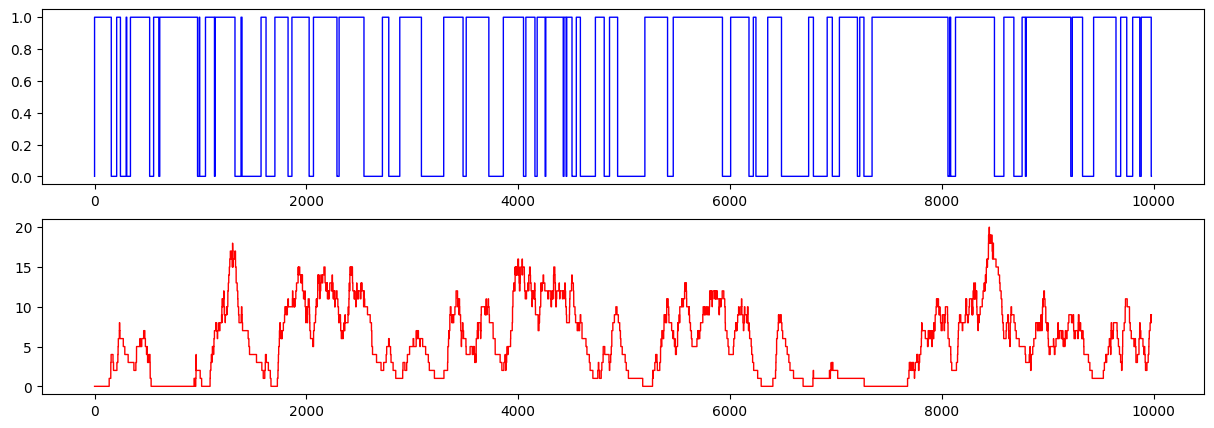

In [ ]:
t,ga,r = reaction(kb = 0.01, ku = 0.01, k1 = 0.1, k2 = 0.01,T = 10000, dynamic_plotting=True)